In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Automatic Mixed Precision
=========================

**Author**: [Michael Carilli](https://github.com/mcarilli)

[torch.cuda.amp](https://pytorch.org/docs/stable/amp.html) provides
convenience methods for mixed precision, where some operations use the
`torch.float32` (`float`) datatype and other operations use
`torch.float16` (`half`). Some ops, like linear layers and convolutions,
are much faster in `float16` or `bfloat16`. Other ops, like reductions,
often require the dynamic range of `float32`. Mixed precision tries to
match each op to its appropriate datatype, which can reduce your
network\'s runtime and memory footprint.

Ordinarily, \"automatic mixed precision training\" uses
[torch.autocast](https://pytorch.org/docs/stable/amp.html#torch.autocast)
and
[torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler)
together.

This recipe measures the performance of a simple network in default
precision, then walks through adding `autocast` and `GradScaler` to run
the same network in mixed precision with improved performance.

You may download and run this recipe as a standalone Python script. The
only requirements are PyTorch 1.6 or later and a CUDA-capable GPU.

Mixed precision primarily benefits Tensor Core-enabled architectures
(Volta, Turing, Ampere). This recipe should show significant (2-3X)
speedup on those architectures. On earlier architectures (Kepler,
Maxwell, Pascal), you may observe a modest speedup. Run `nvidia-smi` to
display your GPU\'s architecture.


In [3]:
import torch, time, gc

# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

A simple network
================

The following sequence of linear layers and ReLUs should show a speedup
with mixed precision.


In [4]:
def make_model(in_size, out_size, num_layers):
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers)).cuda()

`batch_size`, `in_size`, `out_size`, and `num_layers` are chosen to be
large enough to saturate the GPU with work. Typically, mixed precision
provides the greatest speedup when the GPU is saturated. Small networks
may be CPU bound, in which case mixed precision won\'t improve
performance. Sizes are also chosen such that linear layers\'
participating dimensions are multiples of 8, to permit Tensor Core usage
on Tensor Core-capable GPUs (see
`Troubleshooting<troubleshooting>`{.interpreted-text role="ref"} below).

Exercise: Vary participating sizes and see how the mixed precision
speedup changes.


In [5]:
batch_size = 512 # Try, for example, 128, 256, 513.
in_size = 4096
out_size = 4096
num_layers = 3
num_batches = 50
epochs = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

# Creates data in default precision.
# The same data is used for both default and mixed precision trials below.
# You don't need to manually change inputs' ``dtype`` when enabling mixed precision.
data = [torch.randn(batch_size, in_size) for _ in range(num_batches)]
targets = [torch.randn(batch_size, out_size) for _ in range(num_batches)]

loss_fn = torch.nn.MSELoss().cuda()

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 超参数
batch_size = 512  # 可以尝试 128, 256, 513
in_size = 32 * 32 * 3  # 输入特征大小（CIFAR-10 图像是 32x32 的 RGB 图像）
out_size = 10     # 输出特征大小（CIFAR-10 有 10 个类别）
num_layers = 3    # 网络层数
num_batches = 50  # 批次数
epochs = 3        # 训练轮数

# 设备设置
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 定义图像预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

# 加载 CIFAR-10 数据集
cifar_data = datasets.CIFAR10(
    root="./data",  # 数据集下载路径
    train=True,     # 使用训练集
    download=True,  # 如果数据集不存在，自动下载
    transform=transform,
)

# 创建 DataLoader
dataloader = DataLoader(cifar_data, batch_size=batch_size, shuffle=True)

# 将 CIFAR-10 数据转换为输入和目标
data = []
targets = []
for images, labels in dataloader:
    # 将图像展平为向量 [batch_size, 32*32*3]
    images = images.view(images.size(0), -1).to(device)  # 手动移动到设备
    # 将标签转换为 one-hot 编码 [batch_size, 10]
    labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # 手动移动到设备
    data.append(images)
    targets.append(labels)
    if len(data) >= num_batches:  # 只取 num_batches 个批次
        break

# 定义损失函数
loss_fn = torch.nn.MSELoss().to(device)

# 打印数据形状
print("Data shape:", data[0].shape)  # 应该是 [batch_size, 32*32*3]
print("Targets shape:", targets[0].shape)  # 应该是 [batch_size, 10]

Files already downloaded and verified
Data shape: torch.Size([512, 3072])
Targets shape: torch.Size([512, 10])


In [5]:
import torch

# 检查 GPU 是否可用
print("GPU available:", torch.cuda.is_available())

# 打印当前设备
print("Current device:", torch.cuda.current_device())

# 打印设备名称
print("Device name:", torch.cuda.get_device_name(0))

GPU available: True
Current device: 0
Device name: Tesla T4


Default Precision
=================

Without `torch.cuda.amp`, the following simple network executes all ops
in default precision (`torch.float32`):


In [6]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in range(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
end_timer_and_print("Default precision:")

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(



Default precision:
Total execution time = 2.237 sec
Max memory used by tensors = 490300928 bytes


Adding `torch.autocast`
=======================

Instances of
[torch.autocast](https://pytorch.org/docs/stable/amp.html#autocasting)
serve as context managers that allow regions of your script to run in
mixed precision.

In these regions, CUDA ops run in a `dtype` chosen by `autocast` to
improve performance while maintaining accuracy. See the [Autocast Op
Reference](https://pytorch.org/docs/stable/amp.html#autocast-op-reference)
for details on what precision `autocast` chooses for each op, and under
what circumstances.


In [7]:
for epoch in range(0): # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        # Runs the forward pass under ``autocast``.
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers ``autocast`` to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because ``mse_loss`` layers ``autocast`` to float32.
            assert loss.dtype is torch.float32

        # Exits ``autocast`` before backward().
        # Backward passes under ``autocast`` are not recommended.
        # Backward ops run in the same ``dtype`` ``autocast`` chose for corresponding forward ops.
        loss.backward()
        opt.step()
        opt.zero_grad() # set_to_none=True here can modestly improve performance

In [9]:
def format_memory_size(bytes):
    if bytes < 1024:
        return f"{bytes} B"
    elif bytes < 1024 * 1024:
        return f"{bytes / 1024:.2f} KB"
    elif bytes < 1024 * 1024 * 1024:
        return f"{bytes / (1024 * 1024):.2f} MB"
    else:
        return f"{bytes / (1024 * 1024 * 1024):.2f} GB"

In [10]:
timer_results = []# 用于存储每一次的结果。

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()

    elapsed_time = end_time - start_time #计算运行时间
    max_memory = torch.cuda.max_memory_allocated()#获取程序运行期间张量所使用的最大内存
    timer_results.append((local_msg, elapsed_time, max_memory))#将本次计时的信息 (local_msg)、运行时间 (elapsed_time) 和最大内存使用量 (max_memory) 以元组的形式添加到 timer_results 列表中。

    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(elapsed_time))
    print("Max memory used by tensors =", format_memory_size(max_memory))

In [11]:
# 定义一个简单的模型
model = torch.nn.Linear(1000, 1000).cuda() #创建一个线性模型 model
input_data = torch.randn(1000, 1000).cuda() #创建随机输入数据
# 开始计时
start_timer()
# 模拟前向传播和反向传播
output = model(input_data)
loss = output.sum()
loss.backward()
# 结束计时并打印结果
end_timer_and_print("Linear layer forward + backward pass")


Linear layer forward + backward pass
Total execution time = 0.013 sec
Max memory used by tensors = 408.86 MB


In [13]:
# 定义模型
model = make_model(in_size, out_size, num_layers).to(device)

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练循环
for epoch in range(epochs):
    start_timer()  # 开始计时
    for i in range(num_batches):
        # 获取当前批次的数据和目标
        inputs = data[i].to(device)
        labels = targets[i].to(device)

        # 前向传播
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 结束计时并打印结果
    end_timer_and_print(f"Epoch {epoch + 1} completed")


Epoch 1 completed
Total execution time = 0.961 sec
Max memory used by tensors = 765.79 MB

Epoch 2 completed
Total execution time = 0.791 sec
Max memory used by tensors = 765.79 MB

Epoch 3 completed
Total execution time = 0.792 sec
Max memory used by tensors = 765.79 MB


In [14]:
def print_memory_usage(prefix=""):
 if torch.cuda.is_available():
     print(f"{prefix} Memory allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
     print(f"{prefix} Memory reserved: {torch.cuda.memory_reserved() / 1e6:.2f} MB")

# 在训练循环中添加显存监控
for epoch in range(epochs):
 start_timer()
 for i in range(num_batches):
     inputs = data[i].to(device)
     labels = targets[i].to(device)

     outputs = model(inputs)
     loss = loss_fn(outputs, labels)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     # 每 10 个批次打印一次显存使用情况
     if i % 10 == 0:
         print_memory_usage(f"Epoch {epoch + 1}, Batch {i + 1}")
 end_timer_and_print(f"Epoch {epoch + 1} completed")

Epoch 1, Batch 1 Memory allocated: 727.34 MB
Epoch 1, Batch 1 Memory reserved: 876.61 MB
Epoch 1, Batch 11 Memory allocated: 727.34 MB
Epoch 1, Batch 11 Memory reserved: 876.61 MB
Epoch 1, Batch 21 Memory allocated: 727.34 MB
Epoch 1, Batch 21 Memory reserved: 876.61 MB
Epoch 1, Batch 31 Memory allocated: 727.34 MB
Epoch 1, Batch 31 Memory reserved: 876.61 MB
Epoch 1, Batch 41 Memory allocated: 727.34 MB
Epoch 1, Batch 41 Memory reserved: 876.61 MB

Epoch 1 completed
Total execution time = 0.846 sec
Max memory used by tensors = 765.79 MB
Epoch 2, Batch 1 Memory allocated: 727.34 MB
Epoch 2, Batch 1 Memory reserved: 876.61 MB
Epoch 2, Batch 11 Memory allocated: 727.34 MB
Epoch 2, Batch 11 Memory reserved: 876.61 MB
Epoch 2, Batch 21 Memory allocated: 727.34 MB
Epoch 2, Batch 21 Memory reserved: 876.61 MB
Epoch 2, Batch 31 Memory allocated: 727.34 MB
Epoch 2, Batch 31 Memory reserved: 876.61 MB
Epoch 2, Batch 41 Memory allocated: 727.34 MB
Epoch 2, Batch 41 Memory reserved: 876.61 MB

Ep

In [15]:
def check_gradients(model):
 for name, param in model.named_parameters():
     if param.grad is not None:
         grad_mean = param.grad.abs().mean().item()
         grad_max = param.grad.abs().max().item()
         print(f"Layer: {name}, Mean Gradient: {grad_mean:.6f}, Max Gradient: {grad_max:.6f}")
     else:
         print(f"Layer: {name}, No Gradient")

# 在训练循环中添加梯度检查
for epoch in range(epochs):
 start_timer()
 for i in range(num_batches):
     inputs = data[i].to(device)
     labels = targets[i].to(device)

     outputs = model(inputs)
     loss = loss_fn(outputs, labels)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     # 每 10 个批次检查一次梯度
     if i % 10 == 0:
         check_gradients(model)
 end_timer_and_print(f"Epoch {epoch + 1} completed")

Layer: 0.weight, Mean Gradient: 0.000002, Max Gradient: 0.000097
Layer: 0.bias, Mean Gradient: 0.000003, Max Gradient: 0.000046
Layer: 2.weight, Mean Gradient: 0.000001, Max Gradient: 0.002881
Layer: 2.bias, Mean Gradient: 0.000000, Max Gradient: 0.000319
Layer: 4.weight, Mean Gradient: 0.000022, Max Gradient: 0.034768
Layer: 4.bias, Mean Gradient: 0.003679, Max Gradient: 0.007571
Layer: 0.weight, Mean Gradient: 0.000002, Max Gradient: 0.000138
Layer: 0.bias, Mean Gradient: 0.000003, Max Gradient: 0.000047
Layer: 2.weight, Mean Gradient: 0.000001, Max Gradient: 0.003137
Layer: 2.bias, Mean Gradient: 0.000000, Max Gradient: 0.000212
Layer: 4.weight, Mean Gradient: 0.000032, Max Gradient: 0.052904
Layer: 4.bias, Mean Gradient: 0.002631, Max Gradient: 0.004801
Layer: 0.weight, Mean Gradient: 0.000003, Max Gradient: 0.000106
Layer: 0.bias, Mean Gradient: 0.000003, Max Gradient: 0.000039
Layer: 2.weight, Mean Gradient: 0.000001, Max Gradient: 0.004185
Layer: 2.bias, Mean Gradient: 0.000000,

In [16]:
from torch.optim.lr_scheduler import StepLR

# 使用学习率调度器
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 每 10 个 epoch 将学习率乘以 0.1

for epoch in range(epochs):
 start_timer()
 for i in range(num_batches):
     inputs = data[i].to(device)
     labels = targets[i].to(device)

     outputs = model(inputs)
     loss = loss_fn(outputs, labels)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

 # 每个 epoch 结束后调整学习率
 scheduler.step()
 print(f"Epoch {epoch + 1}, Learning Rate: {scheduler.get_last_lr()[0]}")
 end_timer_and_print(f"Epoch {epoch + 1} completed")

Epoch 1, Learning Rate: 0.001

Epoch 1 completed
Total execution time = 0.849 sec
Max memory used by tensors = 765.79 MB
Epoch 2, Learning Rate: 0.001

Epoch 2 completed
Total execution time = 0.797 sec
Max memory used by tensors = 765.79 MB
Epoch 3, Learning Rate: 0.001

Epoch 3 completed
Total execution time = 0.800 sec
Max memory used by tensors = 765.79 MB


Epoch 1, Loss: 0.071874

Epoch 1 completed
Total execution time = 0.902 sec
Max memory used by tensors = 765.79 MB
Epoch 2, Loss: 0.071066

Epoch 2 completed
Total execution time = 0.811 sec
Max memory used by tensors = 765.79 MB
Epoch 3, Loss: 0.069617

Epoch 3 completed
Total execution time = 0.811 sec
Max memory used by tensors = 765.79 MB


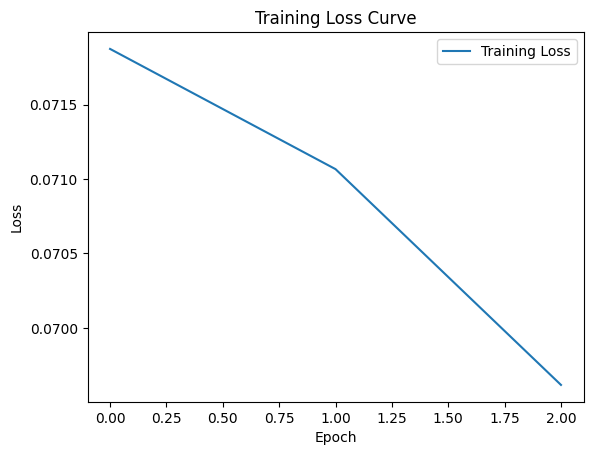

In [17]:
import matplotlib.pyplot as plt

# 记录损失值
loss_history = []

for epoch in range(epochs):
 epoch_loss = 0.0
 start_timer()
 for i in range(num_batches):
     inputs = data[i].to(device)
     labels = targets[i].to(device)

     outputs = model(inputs)
     loss = loss_fn(outputs, labels)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     epoch_loss += loss.item()

 # 记录每个 epoch 的平均损失
 avg_loss = epoch_loss / num_batches
 loss_history.append(avg_loss)
 print(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}")
 end_timer_and_print(f"Epoch {epoch + 1} completed")

# 绘制损失曲线
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

Initial Weight Distribution:


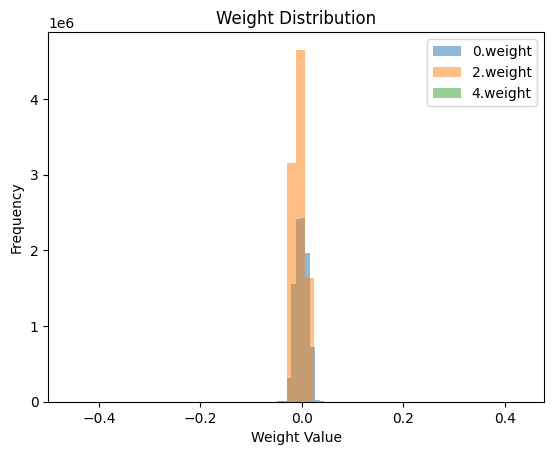


Epoch 1 completed
Total execution time = 0.875 sec
Max memory used by tensors = 765.79 MB

Epoch 2 completed
Total execution time = 0.804 sec
Max memory used by tensors = 765.79 MB

Epoch 3 completed
Total execution time = 0.806 sec
Max memory used by tensors = 765.79 MB
Final Weight Distribution:


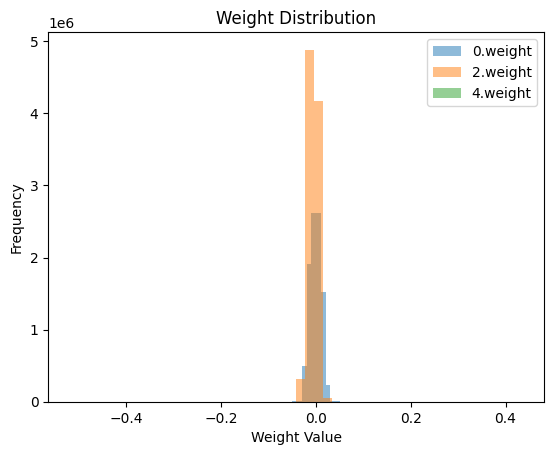

In [18]:
def plot_weight_distribution(model):
 for name, param in model.named_parameters():
     if "weight" in name:
         plt.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.5, label=name)
 plt.xlabel("Weight Value")
 plt.ylabel("Frequency")
 plt.title("Weight Distribution")
 plt.legend()
 plt.show()

# 在训练前后绘制权重分布
print("Initial Weight Distribution:")
plot_weight_distribution(model)

for epoch in range(epochs):
 start_timer()
 for i in range(num_batches):
     inputs = data[i].to(device)
     labels = targets[i].to(device)

     outputs = model(inputs)
     loss = loss_fn(outputs, labels)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
 end_timer_and_print(f"Epoch {epoch + 1} completed")

print("Final Weight Distribution:")
plot_weight_distribution(model)

Adding `GradScaler`
===================

[Gradient
scaling](https://pytorch.org/docs/stable/amp.html#gradient-scaling)
helps prevent gradients with small magnitudes from flushing to zero
(\"underflowing\") when training with mixed precision.

[torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler)
performs the steps of gradient scaling conveniently.


In [12]:
# Constructs a ``scaler`` once, at the beginning of the convergence run, using default arguments.
# If your network fails to converge with default ``GradScaler`` arguments, please file an issue.
# The same ``GradScaler`` instance should be used for the entire convergence run.
# If you perform multiple convergence runs in the same script, each run should use
# a dedicated fresh ``GradScaler`` instance. ``GradScaler`` instances are lightweight.
scaler = torch.amp.GradScaler("cuda")

for epoch in range(0): # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = net(input)
            loss = loss_fn(output, target)

        # Scales loss. Calls ``backward()`` on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # ``scaler.step()`` first unscales the gradients of the optimizer's assigned parameters.
        # If these gradients do not contain ``inf``s or ``NaN``s, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(opt)

        # Updates the scale for next iteration.
        scaler.update()

        opt.zero_grad() # set_to_none=True here can modestly improve performance

All together: \"Automatic Mixed Precision\"
===========================================

(The following also demonstrates `enabled`, an optional convenience
argument to `autocast` and `GradScaler`. If False, `autocast` and
`GradScaler`\'s calls become no-ops. This allows switching between
default precision and mixed precision without if/else statements.)


In [ ]:
use_amp = True

net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.amp.GradScaler("cuda" ,enabled=use_amp)

start_timer()
for epoch in range(epochs):
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
end_timer_and_print("Mixed precision:")

Inspecting/modifying gradients (e.g., clipping)
===============================================

All gradients produced by `scaler.scale(loss).backward()` are scaled. If
you wish to modify or inspect the parameters\' `.grad` attributes
between `backward()` and `scaler.step(optimizer)`, you should unscale
them first using
[scaler.unscale\_(optimizer)](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler.unscale_).


In [ ]:
for epoch in range(0): # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()

        # Unscales the gradients of optimizer's assigned parameters in-place
        scaler.unscale_(opt)

        # Since the gradients of optimizer's assigned parameters are now unscaled, clips as usual.
        # You may use the same value for max_norm here as you would without gradient scaling.
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.1)

        scaler.step(opt)
        scaler.update()
        opt.zero_grad() # set_to_none=True here can modestly improve performance

Saving/Resuming
===============

To save/resume Amp-enabled runs with bitwise accuracy, use
[scaler.state\_dict](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler.state_dict)
and
[scaler.load\_state\_dict](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler.load_state_dict).

When saving, save the `scaler` state dict alongside the usual model and
optimizer state `dicts`. Do this either at the beginning of an iteration
before any forward passes, or at the end of an iteration after
`scaler.update()`.


In [ ]:
checkpoint = {"model": net.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
# Write checkpoint as desired, e.g.,
# torch.save(checkpoint, "filename")

When resuming, load the `scaler` state dict alongside the model and
optimizer state `dicts`. Read checkpoint as desired, for example:

``` {.}
dev = torch.cuda.current_device()
checkpoint = torch.load("filename",
                        map_location = lambda storage, loc: storage.cuda(dev))
```


In [ ]:
net.load_state_dict(checkpoint["model"])
opt.load_state_dict(checkpoint["optimizer"])
scaler.load_state_dict(checkpoint["scaler"])

If a checkpoint was created from a run *without* Amp, and you want to
resume training *with* Amp, load model and optimizer states from the
checkpoint as usual. The checkpoint won\'t contain a saved `scaler`
state, so use a fresh instance of `GradScaler`.

If a checkpoint was created from a run *with* Amp and you want to resume
training *without* `Amp`, load model and optimizer states from the
checkpoint as usual, and ignore the saved `scaler` state.


Inference/Evaluation
====================

`autocast` may be used by itself to wrap inference or evaluation forward
passes. `GradScaler` is not necessary.


Advanced topics
===============

See the [Automatic Mixed Precision
Examples](https://pytorch.org/docs/stable/notes/amp_examples.html) for
advanced use cases including:

-   Gradient accumulation
-   Gradient penalty/double backward
-   Networks with multiple models, optimizers, or losses
-   Multiple GPUs (`torch.nn.DataParallel` or
    `torch.nn.parallel.DistributedDataParallel`)
-   Custom autograd functions (subclasses of `torch.autograd.Function`)

If you perform multiple convergence runs in the same script, each run
should use a dedicated fresh `GradScaler` instance. `GradScaler`
instances are lightweight.

If you\'re registering a custom C++ op with the dispatcher, see the
[autocast
section](https://pytorch.org/tutorials/advanced/dispatcher.html#autocast)
of the dispatcher tutorial.


Troubleshooting
===============

Speedup with Amp is minor
-------------------------

1.  Your network may fail to saturate the GPU(s) with work, and is
    therefore CPU bound. Amp\'s effect on GPU performance won\'t matter.
    -   A rough rule of thumb to saturate the GPU is to increase batch
        and/or network size(s) as much as you can without running OOM.
    -   Try to avoid excessive CPU-GPU synchronization (`.item()` calls,
        or printing values from CUDA tensors).
    -   Try to avoid sequences of many small CUDA ops (coalesce these
        into a few large CUDA ops if you can).
2.  Your network may be GPU compute bound (lots of
    `matmuls`/convolutions) but your GPU does not have Tensor Cores. In
    this case a reduced speedup is expected.
3.  The `matmul` dimensions are not Tensor Core-friendly. Make sure
    `matmuls` participating sizes are multiples of 8. (For NLP models
    with encoders/decoders, this can be subtle. Also, convolutions used
    to have similar size constraints for Tensor Core use, but for CuDNN
    versions 7.3 and later, no such constraints exist. See
    [here](https://github.com/NVIDIA/apex/issues/221#issuecomment-478084841)
    for guidance.)

Loss is inf/NaN
---------------

First, check if your network fits an
`advanced use case<advanced-topics>`{.interpreted-text role="ref"}. See
also [Prefer binary\_cross\_entropy\_with\_logits over
binary\_cross\_entropy](https://pytorch.org/docs/stable/amp.html#prefer-binary-cross-entropy-with-logits-over-binary-cross-entropy).

If you\'re confident your Amp usage is correct, you may need to file an
issue, but before doing so, it\'s helpful to gather the following
information:

1.  Disable `autocast` or `GradScaler` individually (by passing
    `enabled=False` to their constructor) and see if `infs`/`NaNs`
    persist.
2.  If you suspect part of your network (e.g., a complicated loss
    function) overflows , run that forward region in `float32` and see
    if `infs`/`NaN`s persist. [The autocast
    docstring](https://pytorch.org/docs/stable/amp.html#torch.autocast)\'s
    last code snippet shows forcing a subregion to run in `float32` (by
    locally disabling `autocast` and casting the subregion\'s inputs).

Type mismatch error (may manifest as `CUDNN_STATUS_BAD_PARAM`)
--------------------------------------------------------------

`Autocast` tries to cover all ops that benefit from or require casting.
[Ops that receive explicit
coverage](https://pytorch.org/docs/stable/amp.html#autocast-op-reference)
are chosen based on numerical properties, but also on experience. If you
see a type mismatch error in an `autocast` enabled forward region or a
backward pass following that region, it\'s possible `autocast` missed an
op.

Please file an issue with the error backtrace.
`export TORCH_SHOW_CPP_STACKTRACES=1` before running your script to
provide fine-grained information on which backend op is failing.
